# Convert STRING node2vec embeddings to a 2d embedding using UMAP

In [1]:
import umap
import scipy.sparse
import pandas as pd

from utils import get_string_dataset_path

In [2]:
%%time
embedding_high_df = pd.read_csv("data/embeddings/node2vec-128d.tsv.xz", sep="\t", index_col=[0, 1])
embedding_high_df.head(2)

CPU times: user 949 ms, sys: 27 ms, total: 976 ms
Wall time: 975 ms


,,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,emb_7,emb_8,emb_9,emb_10,...,emb_119,emb_120,emb_121,emb_122,emb_123,emb_124,emb_125,emb_126,emb_127,emb_128
node_id,preferred_name,,,,,,,,,,,,,,,,,,,,,
0,ARF5,0.495522,-0.264478,0.383956,-1.48516,1.13501,-0.687379,-0.092868,-0.428224,-0.148345,-0.028783,...,-0.002594,0.308740,-0.062943,0.140117,0.177642,0.132789,0.032162,0.093262,-0.260608,0.014748
1,M6PR,0.371978,-0.189449,0.336587,-1.45652,1.08911,-0.992916,-0.500337,-0.429294,0.179531,-0.128398,...,-0.213474,-0.102929,0.170698,-0.014626,0.150232,0.078505,0.129128,0.193226,-0.458337,0.285326


In [3]:
# Show the head of protein info
gene_path = get_string_dataset_path("protein.info")
gene_df = pd.read_csv(gene_path, sep='\t')
gene_df = gene_df.reset_index()
gene_df.tail(2)

,index,protein_external_id,preferred_name,protein_size,annotation
19564,19564,9606.ENSP00000485675,ENSG00000280116,84,annotation not available
19565,19565,9606.ENSP00000485678,OR6Q1,317,Olfactory receptor 6Q1; Odorant receptor; Olfa...


In [4]:
reducer = umap.UMAP(
    n_components=2,
    random_state=0,
    init="random", # https://github.com/lmcinnes/umap/issues/381
)

In [5]:
%%time
mapper = reducer.fit(embedding_high_df)

CPU times: user 29.8 s, sys: 432 ms, total: 30.3 s
Wall time: 30.3 s


In [6]:
# Create embedding dataframe
umap_df = gene_df.merge(
    pd.DataFrame(mapper.transform(embedding_high_df))
    .add_prefix("umap_")
    .reset_index(drop = False)
    .rename(columns={"node_id": "index"})
)
umap_df.head(2)

,index,protein_external_id,preferred_name,protein_size,annotation,umap_0,umap_1
0,0,9606.ENSP00000000233,ARF5,180,ADP-ribosylation factor 5; GTP-binding protein...,12.868138,2.650041
1,1,9606.ENSP00000000412,M6PR,277,Cation-dependent mannose-6-phosphate receptor;...,5.868094,7.865096


In [7]:
len(umap_df)

19354

In [8]:
# %%time
# from sklearn.cluster import DBSCAN
# from sklearn.preprocessing import StandardScaler
# # https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html
# cluster_model = DBSCAN(eps=0.5, min_samples=5)
# clusters = cluster_model.fit_predict(StandardScaler().fit_transform(embedding_high_df))
# clusters[:5]

### cluster

cluster high dimensional embedding for coloring the 2d scatterplot

In [9]:
%%time
from sklearn.cluster import DBSCAN, KMeans
from sklearn.preprocessing import StandardScaler
# https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html
cluster_model = KMeans(n_clusters=100, random_state=0)
clusters = cluster_model.fit_predict(StandardScaler().fit_transform(embedding_high_df))
umap_df["cluster"] = clusters
umap_df.head(2)

CPU times: user 57.4 s, sys: 29.7 s, total: 1min 27s
Wall time: 27.9 s


,index,protein_external_id,preferred_name,protein_size,annotation,umap_0,umap_1,cluster
0,0,9606.ENSP00000000233,ARF5,180,ADP-ribosylation factor 5; GTP-binding protein...,12.868138,2.650041,45
1,1,9606.ENSP00000000412,M6PR,277,Cation-dependent mannose-6-phosphate receptor;...,5.868094,7.865096,77


In [10]:
umap_df.to_csv("data/embeddings/node2vec-128d-to-umap-2d.tsv.xz", sep="\t", index=False)

## Plot embeddings

In [11]:
import umap.plot

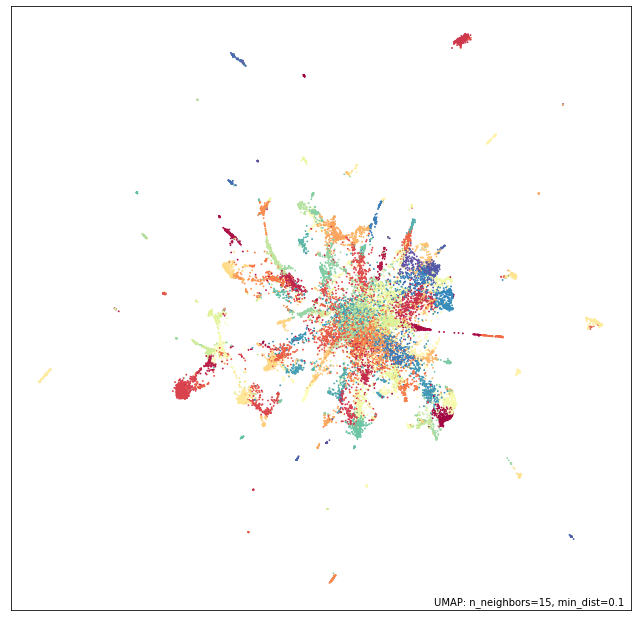

In [12]:
umap.plot.points(mapper, labels=clusters, show_legend=False);

In [13]:
# based on example at https://umap-learn.readthedocs.io/en/latest/basic_usage.html
import bokeh.plotting
import bokeh.models
import bokeh.palettes
import colorcet

umap_df["cluster_color"] = umap_df.cluster.map(dict(enumerate(colorcet.glasbey_dark)))
datasource = bokeh.models.ColumnDataSource(umap_df)

plot_title = 'UMAP projection of STRING proteins (via node2vec)'
figure = bokeh.plotting.figure(
    title=plot_title,
    plot_width=600,
    plot_height=600,
    tools='box_zoom, pan, wheel_zoom, reset'
)

hover_tool = bokeh.models.HoverTool(
    tooltips=[
        ('symbol', '<i>@preferred_name</i>'),
        ('protein_size',  '@protein_size{,}'),
        ('info', '@annotation'),
        ('cluster', '@cluster'),
    ],
)
figure.add_tools(hover_tool)

figure.circle(
    x='umap_0',
    y='umap_1',
    source=datasource,
    color="cluster_color",
    line_alpha=0.6,
    fill_alpha=0.6,
    radius=0.01
)

GlyphRenderer(id='1036', ...)

In [14]:
# Uncomment below to display plot in notebook
# bokeh.plotting.output_notebook()
# bokeh.plotting.show(figure)

In [15]:
import bokeh.resources
bokeh.plotting.save(
    obj=figure,
    resources=bokeh.resources.CDN,
    title=plot_title,
    filename="data/embeddings/node2vec-128d-to-umap-2d.html",
)

'/user/jupyter/data/embeddings/node2vec-128d-to-umap-2d.html'